# Prova de Valorização 2022/2023

In [1]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt

import time

# Alínea 1

Temos a seguinte equação de movimento para o pêndulo:

$$
\begin{align*}
\ddot\theta(t) &= -\frac gR\sin\theta(t)
\end{align*}
$$

Esta é uma EDO de segunda ordem, que podemos separar em duas EDOs de primeira ordem da seguinte forma:

$$
\begin{align*}
\dot\theta(t) &= \omega(t)
\\\\
\dot\omega(t) &= -\frac gR\sin\theta(t)
\end{align*}
$$

Como o pêndulo é largado com um ângulo inicial $\theta_0$ sabemos que a sua velocidade inicial é nula, pelo que temos as seguintes condições iniciais:

$$
\begin{align*}
\theta(0) = \theta_0
\\\\
\omega(0) = 0
\end{align*}
$$

---

Sabemos ainda que o período do pêndulo na aproximação harmónica é dado por:

$$
\begin{align*}
\omega^2 = \frac gR &\Leftrightarrow \left(\frac{2\pi}{\Tau_0}\right)^2 = \frac gR
\\\\
&\Leftrightarrow \Tau_0 = 2\pi\sqrt\frac{R}{g}
\end{align*}
$$

Para facilitar os nossos cálculo podemos então escolher unidades onde $R$ e $g$ sejam ambos $1$, pelo que o período harmónico será $2\pi$.

Vamos seguir o seguinte procedimento:
- Ajustar a rotina geral de RK4 Adaptativo para várias variáveis.
- Alterar a rotina geral para que procure um comportamento periódico na variável $\theta$ com a precisão desejada.

In [2]:
def rk4a(start: float, end: float, func: Callable, eps: float, x0: np.ndarray, h0: float=1e-6, el: bool=False) -> tuple[np.ndarray, np.ndarray]:
    """
        Resolve a equação diferencial `dx/dt = func(x, t)` usando o método de Runge-Kutta Adaptativo de Ordem 4 começando em `start` e terminando em `end` com erro total `eps` sendo `x(start) = x0` e sendo o primeiro passo de comprimento `h0`. Usa extrapolação local se `el` for `True`.

        A função `func` deve aceitar dois argumentos: um array `x` e um float `t`.
        
        O argumento `x0` deve também ser um array.

        ### Retorno
        tt: Array com os valores da variável independente `t`
        xx: Array com os resultados em função de `t`
    """

    # Erro por unidade de tempo
    delta = eps / (end - start)

    # Array onde vamos guardar a solução final
    tt = [start]
    xx = [x0]

    # Passo RK4
    def passo(xn: (float | np.ndarray), tn: float, func: Callable, h: float) -> (float | np.ndarray):
        k1 = func(xn, tn)
        k2 = func(xn + h/2 * k1, tn + h/2)
        k3 = func(xn + h/2 * k2, tn + h/2)
        k4 = func(xn + h * k3, tn + h)
        
        return xn + h * (k1 + 2*k2 + 2*k3 + k4)/6
    

    # Ajustar h de forma limitada (não permitir que h mais que duplique)
    def novoh(velhoh: float, rho: float) -> float:
        valorh = velhoh * rho**(1/4)
        limiteh = 2 * velhoh
        return valorh if abs(valorh) < abs(limiteh) else limiteh


    # Valor inicial de x, t e de h
    xstart = x0
    tstart = start
    h = h0

    toend = False
    while True:
        # Dois passos de tamanho h
        xtemp = passo(xstart, tstart, func, h)
        x1h = passo(xtemp, tstart + h, func, h)

        # Um passo de tamanho 2h
        x2h = passo(xstart, tstart, func, 2 * h)

        # Calcular erros em cada variável
        epsvars = np.array(abs(x1h - x2h) / 30)
        
        # Expressão para o erro total, vamos usar apenas o ângulo theta, que é a variável de interesse! 
        epspasso = abs(epsvars[0])

        # Evitar erro de divsão por zero!
        epspasso = max(epspasso, 1e-16)

        # Calcular rho
        rho = float(abs(h * delta) / abs(epspasso))

        # A precisão foi melhor que o necessário
        if rho > 1:
            # Guardar os valores
            if el:
                tt += [tstart + h, tstart + 2 * h]
                xx += [xtemp + epsvars, x1h + 2 * epsvars]
            else:
                tt += [tstart + h, tstart + 2 * h]
                xx += [xtemp, x1h]

            # Avançar o tempo
            tstart = tt[-1]
            xstart = xx[-1]
            
            # Ajustar h
            h = novoh(h, rho)

            if toend:
                break

        # A precisão foi pior que o necessário
        else:
            # Ajustar h
            # Aqui multiplicamos por 0.99 para evitar que caso rho ~ 1 o valor de h não se altere e o programa entre em loop infinito
            h = 0.99 * novoh(h, rho)

            # Afinal não deve terminar ainda pois o h não era bom o suficiente
            toend = False
            
        
        # Certificar que há um ponto em t = end
        if (h > 0 and tstart + 2 * h >= end) or (h < 0 and tstart + 2 * h <= end):
            # Selecionar um h adequado (será sempre menor ou igual ao h atual, pelo que o programa irá de facto terminar!)
            h = (end - tstart) / 2
            
            # Flag para terminar o processo na próxima iteração
            toend = True
    
    return np.array(tt), np.array(xx)

In [3]:
def rk4aP(start: float, end: float, func: Callable, eps: float, x0: np.ndarray, h0: float=1e-6, el: bool=False, sens: float=1e-2, prec: float=1e-5) -> tuple[np.ndarray, np.ndarray, float]:
    """
        Ajusta o método `rk4a` definido acima para que termine quando encontre um comportamento periódico na primeira variável, procurando determinar o período com precisão `prec`.
    """

    # Erro por unidade de tempo
    delta = eps / (end - start)

    # Array onde vamos guardar a solução final
    tt = [start]
    xx = [x0]

    # Passo RK4
    def passo(xn: (float | np.ndarray), tn: float, func: Callable, h: float) -> (float | np.ndarray):
        k1 = func(xn, tn)
        k2 = func(xn + h/2 * k1, tn + h/2)
        k3 = func(xn + h/2 * k2, tn + h/2)
        k4 = func(xn + h * k3, tn + h)
        
        return xn + h * (k1 + 2*k2 + 2*k3 + k4)/6
    

    # Ajustar h de forma limitada (não permitir que h mais que duplique)
    def novoh(velhoh: float, rho: float) -> float:
        valorh = velhoh * rho**(1/4)
        limiteh = 2 * velhoh
        return valorh if abs(valorh) < abs(limiteh) else limiteh


    # Valor inicial de x, t e de h
    xstart = x0
    tstart = start
    h = h0

    toend = False
    while True:
        # Dois passos de tamanho h
        xtemp = passo(xstart, tstart, func, h)
        x1h = passo(xtemp, tstart + h, func, h)

        # Um passo de tamanho 2h
        x2h = passo(xstart, tstart, func, 2 * h)

        # Calcular erros em cada variável
        epsvars = np.array(abs(x1h - x2h) / 30)
        
        # Expressão para o erro total, vamos usar apenas o ângulo theta, que é a variável de interesse! 
        epspasso = abs(epsvars[0])

        # Evitar erro de divsão por zero!
        epspasso = max(epspasso, 1e-16)

        # Calcular rho
        rho = float(abs(h * delta) / abs(epspasso))

        # A precisão foi melhor que o necessário
        if rho > 1:
            # Guardar os valores
            if el:
                tt += [tstart + h, tstart + 2 * h]
                xx += [xtemp + epsvars, x1h + 2 * epsvars]
            else:
                tt += [tstart + h, tstart + 2 * h]
                xx += [xtemp, x1h]

            # Avançar o tempo
            tstart = tt[-1]
            xstart = xx[-1]
            
            # Ajustar h
            h = novoh(h, rho)

            if toend:
                break

        # A precisão foi pior que o necessário
        else:
            # Ajustar h
            # Aqui multiplicamos por 0.99 para evitar que caso rho ~ 1 o valor de h não se altere e o programa entre em loop infinito
            h = 0.99 * novoh(h, rho)

            # Afinal não deve terminar ainda pois o h não era bom o suficiente
            toend = False
            
        
        # Certificar que há um ponto em t = end
        if (h > 0 and tstart + 2 * h >= end) or (h < 0 and tstart + 2 * h <= end):
            # Selecionar um h adequado (será sempre menor ou igual ao h atual, pelo que o programa irá de facto terminar!)
            h = (end - tstart) / 2
            
            # Flag para terminar o processo na próxima iteração
            toend = True
        
        
        # Procurar periodicidade
        # Vamos usar o facto de o ângulo apenas voltar a atingir o seu máximo passado meio período!
        if len(xx) > 5:

            # O ângulo está a aumentar, estamos junto do período, vamos dar passos de tamanho `prec` e parar quando nos começarmos a afastar do ângulo máximo!
            if xx[-1][0] > xx[-2][0]:

                xstart = xx[-2]
                tstart = tt[-2]

                h = prec

                while True:
                    xnext = passo(xstart, tstart, func, h)
                    tnext = tstart + h

                    # O ângulo começou a aumentar!
                    if xnext[0] > xstart[0]:
                        return np.array(tt), np.array(xx), (tstart + tnext)

                    # O ângulo ainda não começou a aumentar
                    if tnext > tt[-1]:
                        return np.array(tt), np.array(xx), tt[-1] * 2

                    # Próximo passo
                    xstart = xnext
                    tstart = tnext
    
    return np.array(tt), np.array(xx), 0

Text(0, 0.5, 'Período (múltiplos de $T_0$)')

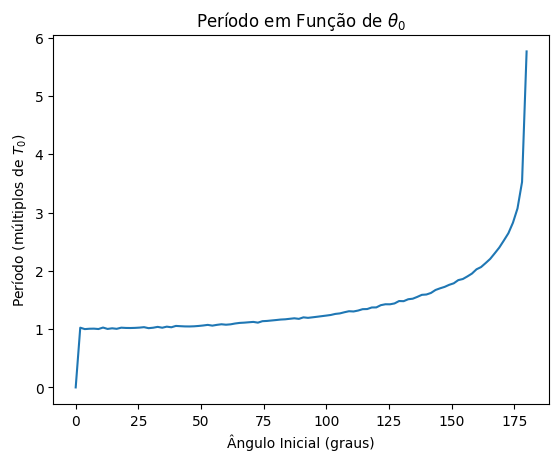

In [4]:
def rhs(x: np.ndarray, t: np.ndarray) -> np.ndarray:
    """
        Lado direito da equação diferencial que descreve o nosso problema.
    """
    theta, omega = x
    return np.array([omega, -np.sin(theta)])


# Parâmetros
N = 100


# Condições Iniciais
thetas = np.linspace(0, np.pi-1e-3, N)
tautau = []

for th in thetas:
    # Não há oscilação
    if th == 0:
        tau = 0
    
    # Os parâmetros aqui usados foram obtidos através de tetativa e erro
    else:
        # Obter os resultados
        # A precisão obtida para o período é apenas aproximadamente `prec`, daí escolhermos este valor menor que 1e-5 como diz no enunciado
        tt, xx, tau = rk4aP(0, 100, rhs, 1e-7, np.array([th, 0]), el=True, prec=1e-6)
        aa, oo = [i[0] for i in xx], [i[1] for i in xx]

        if tau == 0:
            print(f"Erro para theta = {th}.")

    tautau += [tau]


# Representar graficamente
plt.plot(thetas * (180 / np.pi), np.array(tautau) / (2 * np.pi))
plt.title("Período em Função de $\\theta_0$")
plt.xlabel("Ângulo Inicial (graus)")
plt.ylabel("Período (múltiplos de $T_0$)")

Este gráfico revela alguns dos comportamentos esperados do pêndulo anarmónico:
- Para oscilações de pequena amplitude o seu período é muito próximo do período obtido na aproximação harmónica, uma vez que essa aproximação é válida para $\theta \ll 1$ (pois consiste em fazer uma aproximação em série de Taylor de $\sin(\theta)$ e considerar apenas o termo linear).
- Para oscilações de grande amplitude o período aumenta muito, pois o pêndulo começa invertido, pelo que a componente tangencial do peso é muito pequena!

## Alínea 2

Podemos começar por escrever o integral de modo a explicitar os problemas que poderemos encontrar, tendo em conta que $R =1$ e $g = 1$.

$$
\begin{align*}
T_{\theta_0} &= 4 \int_0^{\theta_0}\frac1{\sqrt{2(\cos\theta - \cos\theta_0)}}\ d\theta
\\\\
&= 2\sqrt 2 \int_0^{\theta_0}\frac1{\sqrt{\cos\theta - \cos\theta_0}}\ d\theta
\end{align*}
$$

Percebemos imediatamente que não podemos avaliar a função integranda em $\theta = \theta_0$, pois nesse caso estariamos a tentar dividir por $0$. Isto significa que:
- Temos de fazer uma mudança de variável OU
- Temos que usar um método que não avalie a função nos seus extremos!

Vamos tentar calcular o integral sem fazer mudança de variável. A segunda condição exclui todos os métodos que conhecemos exceto 1: Quadratura gaussiana.

In [5]:
def quadgausseasy(start: float, end: float, func: Callable, n: int) -> float:
    """
        Calcula o integral de `func` de `start` a `end` usando quadratura gaussiana com `n` pontos.

        ### Retorno
        Devolve o valor do integral.
    """

    # Determinar zeros e pesos
    xx, ww = np.polynomial.legendre.leggauss(n)

    # Calcular valores úteis
    dif = end - start
    som = end + start

    # Fazer com que o integral seja de -1 a 1
    def f(x: (float | np.ndarray)) -> (float | np.ndarray):
        return func((x * dif + som) / 2)
    
    return float((dif / 2) * np.sum(f(xx) * ww))

O período para o maior theta0 foi 2.79831
O período para o maior theta0 foi 3.58570
O período para o maior theta0 foi 4.35618
O período para o maior theta0 foi 4.99139
O período para o maior theta0 foi 5.37098
O período para o maior theta0 foi 5.54946
O período para o maior theta0 foi 5.63567
O período para o maior theta0 foi 5.67855


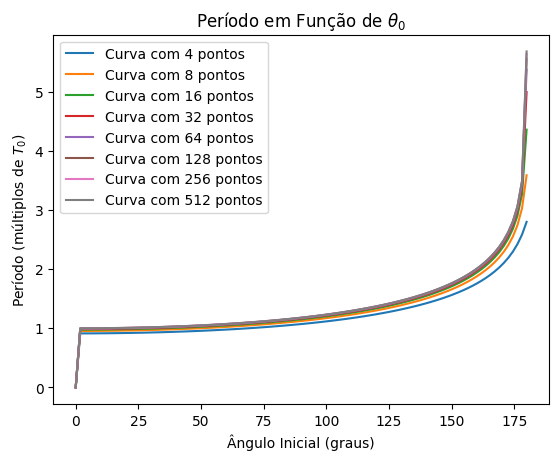

In [6]:
# Definir a função integranda
def integranda(x: np.ndarray, theta0: float) -> np.ndarray:
    return 1 / (np.cos(x) - np.cos(theta0))**0.5


# Parâmetros
N = 100

# Período para cada condição inicial
thetas = np.linspace(0, np.pi-1e-3, N)

# Verificar se o integral converge para algum resultado!
# Se formos até 2**12 conseguimos uma precisão de cerca de 0.01 no período com ângulo inicial máximo.
for P in 2**np.arange(2, 10, 1):
    tautau = []
    for th in thetas:
        if th == 0:
            tau = 0
        
        else:
            tau = 2 * np.sqrt(2) * quadgausseasy(0, th, lambda x: integranda(x, th), P)

        # Guardar os períodos
        tautau += [tau]


    # Representar graficamente
    plt.plot(thetas * (180 / np.pi), np.array(tautau) / (2 * np.pi), label=f"Curva com {P} pontos")
    plt.legend()
    plt.title("Período em Função de $\\theta_0$")
    plt.xlabel("Ângulo Inicial (graus)")
    plt.ylabel("Período (múltiplos de $T_0$)")
    
    print(f"O período para o maior theta0 foi {tautau[-1]/(2 * np.pi):.5f}")
plt.show()


Fazendo os cálculo até $P = 2^{12}$ percebemos que este método de facto converge, mas muito lentamente (com este valor de $N$ conseguimos apenas 2 dígitos de precisão no período do caso de maior amplitude inicial)!

Por isso, vamos usar um número de pontos adapatativo: duplicamos o número de pontos usado para cada valor de $\theta_0$ até que a variação do resultado seja menor que um dado `eps`!

In [7]:
def intP(thetas: float, P0: int=2, Pmax: int=2**12, eps: float=1e-3) -> list:
    """
        Calcula o período do oscilador do problema usando uma aproximação numérica ao integral exato, obtida usando quadratura gaussiana com um número de pontos adaptativo começando com `P0` pontos e duplicando até um máximo de `Pmax`!
    """

    tautau = []
    for th in thetas:
        if th == 0:
            tau = 0

        else:
            # Número de pontos inicial
            P = P0

            # Primeira aproximação
            tau = 2 * np.sqrt(2) * quadgausseasy(0, th, lambda x: integranda(x, th), P)

            erro = eps + 1
            while erro > eps:
                # Duplicar os pontos e voltar a aproximar
                P *= 2
                novotau = 2 * np.sqrt(2) * quadgausseasy(0, th, lambda x: integranda(x, th), P)

                # Calcular o erro
                erro = abs(novotau - tau)

                # Próximo passo
                tau = novotau

                # Parar se P ficar demasiado grande
                if P > Pmax:
                    break

        # Guardar os períodos
        tautau += [tau]
    
    return tautau

O período para o maior theta0 foi 5.71875


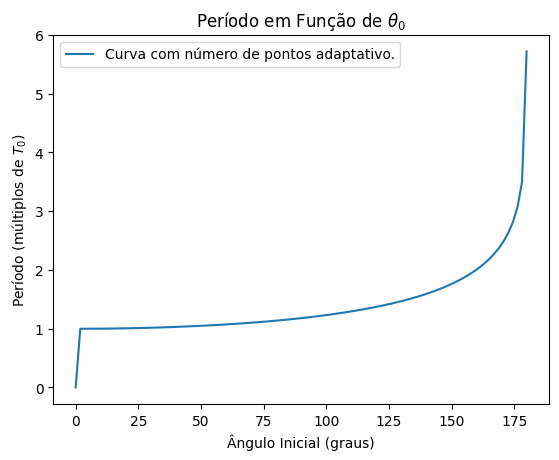

In [8]:
# Definir a função integranda
def integranda(x: np.ndarray, theta0: float) -> np.ndarray:
    return 1 / (np.cos(x) - np.cos(theta0))**0.5


# Parâmetros
N = 100

# Período para cada condição inicial
thetas = np.linspace(0, np.pi-1e-3, N)

# Calcular períodos
tautau = intP(thetas, P0=2, Pmax=2**12, eps=1e-2)

# Representar graficamente
plt.plot(thetas * (180 / np.pi), np.array(tautau) / (2 * np.pi), label=f"Curva com número de pontos adaptativo")
plt.legend()
plt.title("Período em Função de $\\theta_0$")
plt.xlabel("Ângulo Inicial (graus)")
plt.ylabel("Período (múltiplos de $T_0$)")

print(f"O período para o maior theta0 foi {tautau[-1]/(2 * np.pi):.5f}.")
plt.show()


# Alínea 3

In [9]:
# Parâmetros
thetas = np.array([np.pi/8, np.pi/6, np.pi/2, 2 * np.pi/3, 3.14])

## Questão a)

Podemos ver que a forma usada para calcular o período é de facto boa, uma vez que nos gráficos podemos ver sempre 5 períodos completos de oscilação!

Logo, o método de intração escolhido converge.

Vemos também que, como seria de esperar, o período torna-se mais próximo de $T_0$ para $\theta_0$ mais pequeno, uma vez que no eixo $x$ dos gráficos temos cerca de $5T_0$.

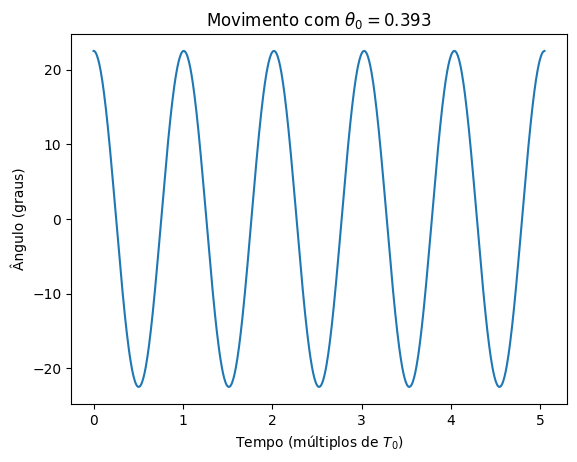

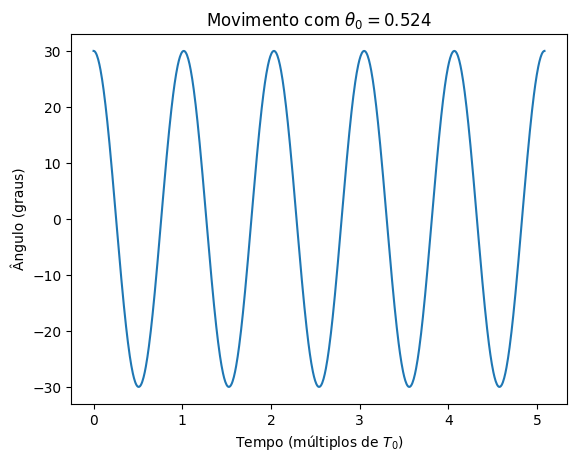

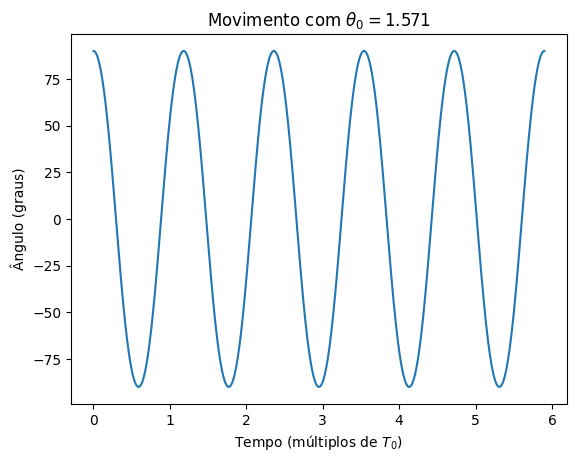

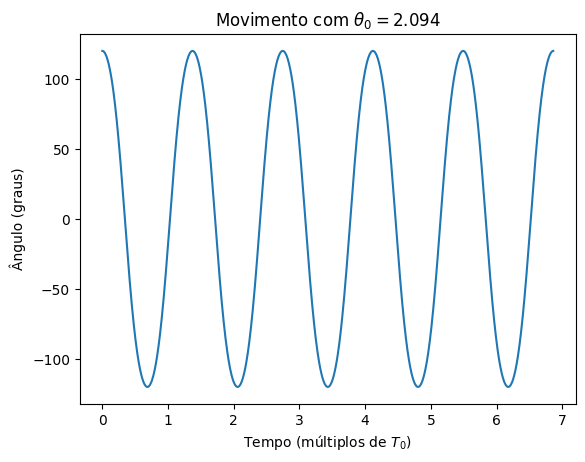

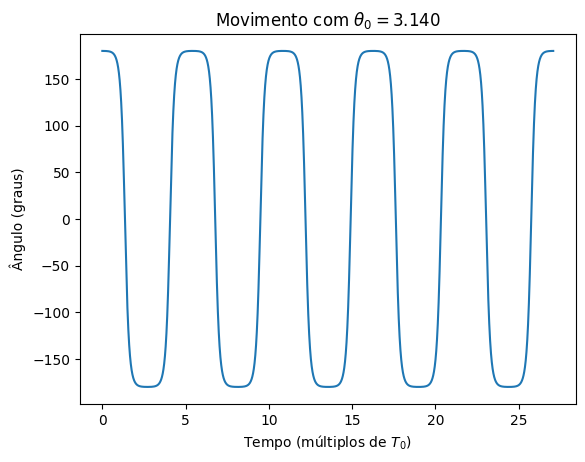

In [15]:
# Calcular o período de movimento com a precisão desejada
tautau = intP(thetas, P0=8, Pmax=2**10, eps=1e-3) 

for th, tau in zip(thetas, tautau):
    # Obter os resultados
    tt, xx = rk4a(0, 5 * tau, rhs, 1e-7, np.array([th, 0]), el=True)
    aa, oo = np.array([i[0] for i in xx]), np.array([i[1] for i in xx])

    # Representar graficamente
    plt.plot(tt / (2 * np.pi), aa * (180 / np.pi))
    plt.title(f"Movimento com $\\theta_0 = {th:.3f}$")
    plt.xlabel("Tempo (múltiplos de $T_0$)")
    plt.ylabel("Ângulo (graus)")
    plt.show()

## Questão b)

Para fazer a FFT com significado físico temos de ter pontos igualmente espaçados! Por isso não podemos usar um passo adaptativo.

In [19]:
def rk4(start: float, end: float, func: Callable, N: int, x0: (float | np.ndarray)) -> tuple[np.ndarray, np.ndarray]:
    """
        Resolve o sistema de K EDOs `dx/dt = func(x, t)` usando o método de Runge-Kutta Clássico de Ordem 4 começando em `start` e terminando em `end` com `N` passos sendo `x(start) = x0`.

        A função `func` deve aceitar dois argumentos: um array `x` com K entradas e um float `t`. O argumento `x0` deve também ter K entradas.

        ### Retorno
        tt: Array com os valores da variável independente `t`
        xx: Array com os resultados em função de `t` sendo que para K > 1 cada elemento do array é um array com o valor das várias funções em `t`.
    """

    # Passo
    h = (end - start) / N
    tt = [start]
    xx = [x0]

    for step in range(N):
        xn = xx[step]
        tn = tt[step]

        k1 = func(xn, tn)
        k2 = func(xn + h/2 * k1, tn + h/2)
        k3 = func(xn + h/2 * k2, tn + h/2)
        k4 = func(xn + h * k3, tn + h)
        
        xx += [xn + h * (k1 + 2*k2 + 2*k3 + k4)/6]
        tt += [tn + h]
    
    return np.array(tt), np.array(xx)

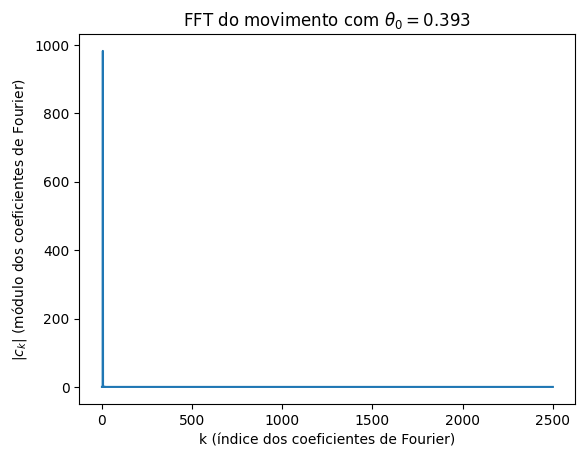

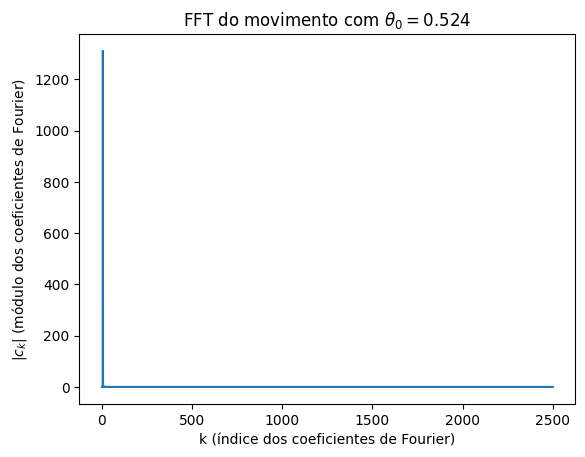

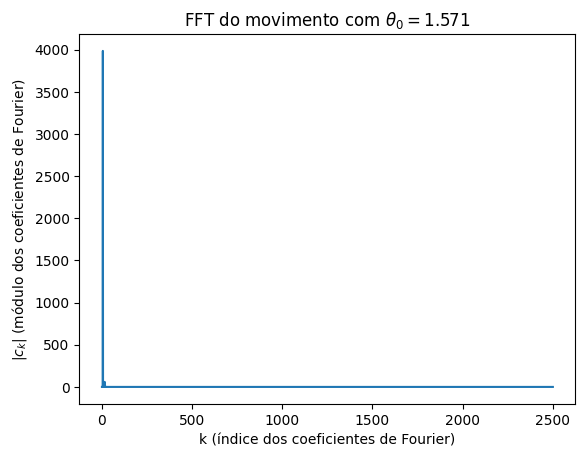

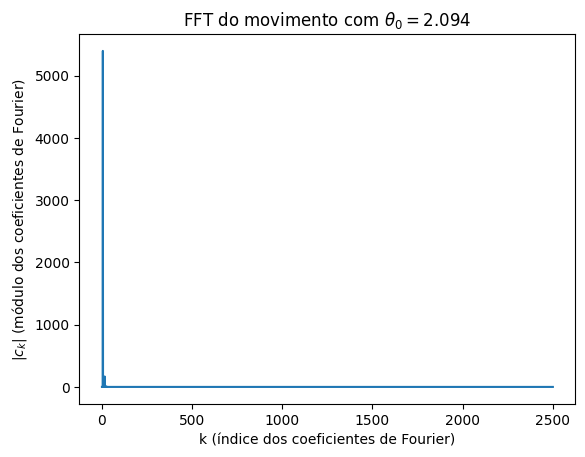

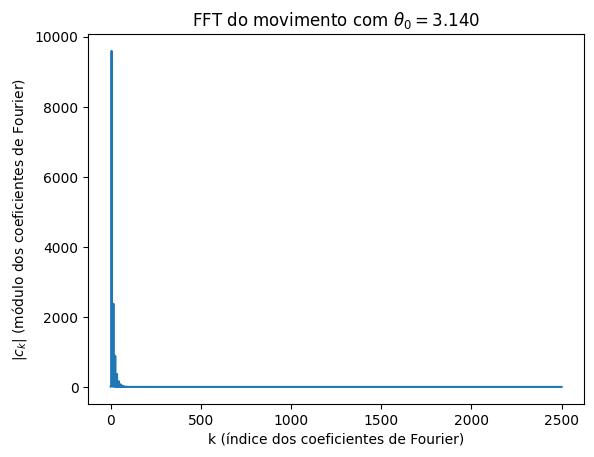

In [22]:
for th, tau in zip(thetas, tautau):
    # Obter os resultados
    tt, xx = rk4(0, 5 * tau, rhs, 5000, np.array([th, 0]))
    aa, oo = np.array([i[0] for i in xx]), np.array([i[1] for i in xx])

    # Fazer a FFT (os ângulos são números reais)
    cc = np.fft.rfft(aa)

    # Representar graficamente
    plt.plot(np.abs(cc))
    plt.title(f"FFT do movimento com $\\theta_0 = {th:.3f}$")
    plt.xlabel("k (índice dos coeficientes de Fourier)")
    plt.ylabel("|$c_k$| (módulo dos coeficientes de Fourier)")
    plt.show()
    

## Questão c)

Vamos focar-nos na zona com k < 50 para vermos o que se está a passar!

---

Podemos perceber que todos os gráficos têm picos em $k = 5 + 10m$ onde $m \in \N$ (pelo menos para os primeiros valores de $m$). Para $k=5$ temos a seguinte frequência associada:

$$
f_k = k \times \frac{1000}{5000} = 1
$$

Onde $1000$ é o número de amostras por unidade de tempo (a unidade de tempo é $T_0$) e $5000$ é o número total de amostras que temos. Logo, o facto de termos um pico elevado em $k = 5$ é fácil de explicar, uma vez que corresponde à frequência da aproximação harmónica, sendo por isso independete das condições iniciais e como tal característica do sistema.

O que aqui é interessante é o facto de termos picos em $k = 5 + 10m$ e não em $k = 5 + 5m$, como seria de esperar se o sistema exibisse ressonâncias em frequências que são múltiplas da sua frequência fundamental (o que aconteceria se fosse regido pela equação de onda).

O que podemos perceber então é que o movimento deste oscilador anarmónico é uma sobreposição de movimentos de osciladores harmónicos com frequências que são múltiplos ímpares da frequência característica do sistema!

Quando a amplitude inicial diminui, a frequência fundamental torna-se cada vez mais significativa!

[  0.016   0.016   0.019   0.025   0.044 982.743   0.036   0.016   0.01
   0.007   0.005   0.004   0.003   0.003   0.002   0.798   0.002   0.001
   0.001   0.001   0.001   0.001   0.001   0.001   0.001   0.001   0.001
   0.001   0.001   0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.   ]


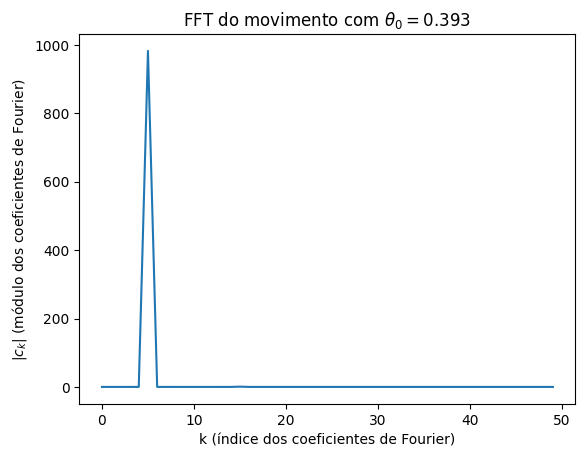

[   0.02     0.02     0.023    0.031    0.055 1311.161    0.045    0.021
    0.013    0.009    0.007    0.005    0.004    0.004    0.003    1.905
    0.002    0.002    0.002    0.001    0.001    0.001    0.001    0.001
    0.001    0.004    0.001    0.001    0.001    0.001    0.001    0.001
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.   ]


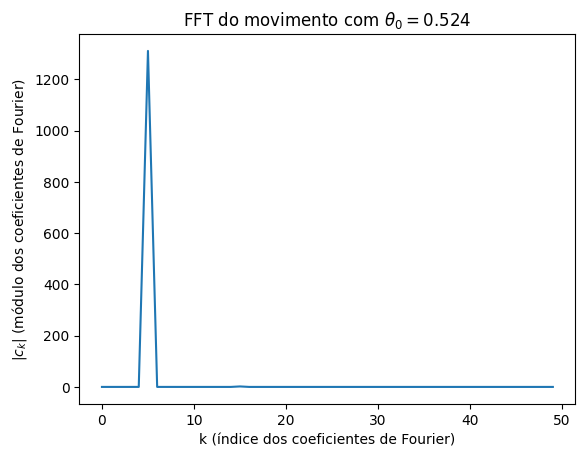

[   0.025    0.026    0.03     0.04     0.071 3986.159    0.058    0.027
    0.017    0.012    0.009    0.007    0.006    0.006    0.007   59.892
    0.       0.001    0.001    0.001    0.001    0.001    0.001    0.001
    0.001    1.554    0.001    0.001    0.001    0.001    0.001    0.001
    0.001    0.001    0.       0.047    0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.002    0.       0.
    0.       0.   ]


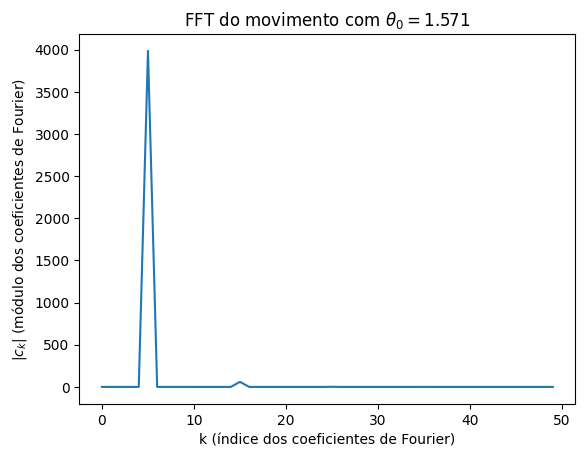

[   0.176    0.183    0.21     0.277    0.497 5396.329    0.418    0.195
    0.124    0.089    0.07     0.059    0.053    0.054    0.07   167.44
    0.022    0.003    0.002    0.004    0.004    0.004    0.004    0.003
    0.001    8.63     0.008    0.006    0.005    0.004    0.004    0.004
    0.004    0.003    0.003    0.526    0.002    0.002    0.002    0.002
    0.002    0.002    0.002    0.002    0.002    0.037    0.002    0.002
    0.001    0.001]


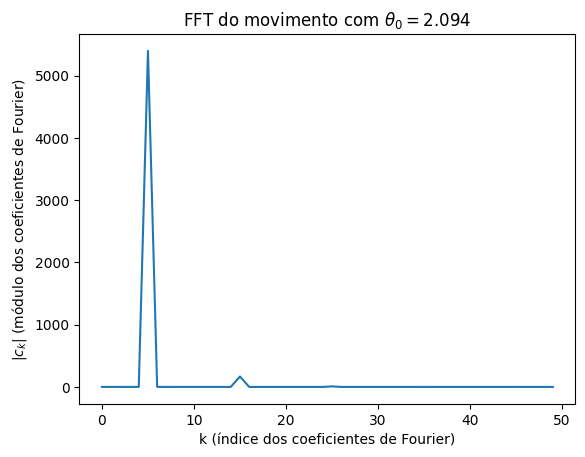

[  11.198   11.761   13.784   18.932   36.731 9595.636   35.335   17.695
   12.497   10.342    9.557    9.749   11.11    14.861   28.167 2376.302
   25.47    12.512    8.664    7.038    6.392    6.417    7.209    9.524
   17.886  889.297   15.624    7.628    5.244    4.23     3.817    3.809
    4.258    5.601   10.5    368.718    8.975    4.379    3.004    2.418
    2.178    2.17     2.423    3.188    5.99   162.371    5.047    2.469
    1.695    1.365]


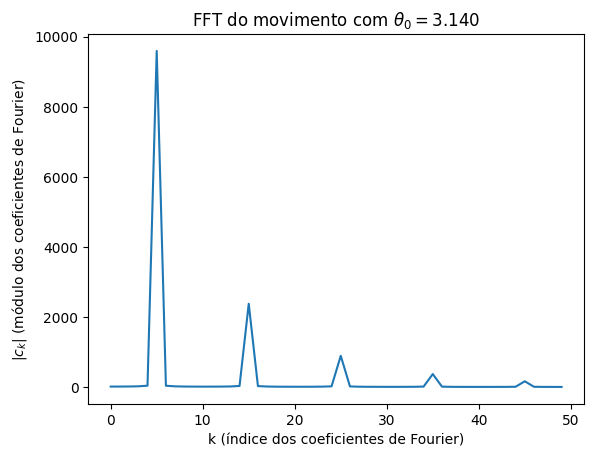

In [31]:
for th, tau in zip(thetas, tautau):
    # Obter os resultados
    tt, xx = rk4(0, 5 * tau, rhs, 5000, np.array([th, 0]))
    aa, oo = np.array([i[0] for i in xx]), np.array([i[1] for i in xx])

    # Fazer a FFT (os ângulos são números reais)
    cc = np.fft.rfft(aa)

    with np.printoptions(precision=3, suppress=True):
        print(f"{np.abs(cc)[:50]}")

    # Representar graficamente
    plt.plot(np.abs(cc)[:50])
    plt.title(f"FFT do movimento com $\\theta_0 = {th:.3f}$")
    plt.xlabel("k (índice dos coeficientes de Fourier)")
    plt.ylabel("|$c_k$| (módulo dos coeficientes de Fourier)")
    plt.show()

## Questão d)

Agora as frequências são dadas por:

$$
f_k = k \times \frac{1000}{500} = 2k
$$

Ou seja, a taxa de amostragem é a mesma mas o número de amostras é muito menor! Em particular, vemos que não há nenhum valor de $k$ correspondente à frequência $f = 1$ ou $f=3$, etc.

Isto é, como vimos acima, as frequências presentes no movimento são $f = 1, 3, 5, \dots$, mas agora não temos resolução suficiente para as capturar, pelo que a transformada de Fourier não tem picos claros, sendo muito mais suave!

Este fenómeno é chamado de *aliasing*.

[ 0.038 83.709 33.377 21.47  15.905 12.653 10.513  8.995  7.862  6.983
  6.282  5.709  5.233  4.83   4.485  4.186  3.924  3.694  3.489  3.306
  3.141  2.992  2.857  2.734  2.62   2.516  2.42   2.331  2.249  2.172
  2.1    2.033  1.971  1.912  1.856  1.804  1.755  1.708  1.664  1.622
  1.582  1.545  1.509  1.474  1.442  1.41   1.381  1.352  1.325  1.299]


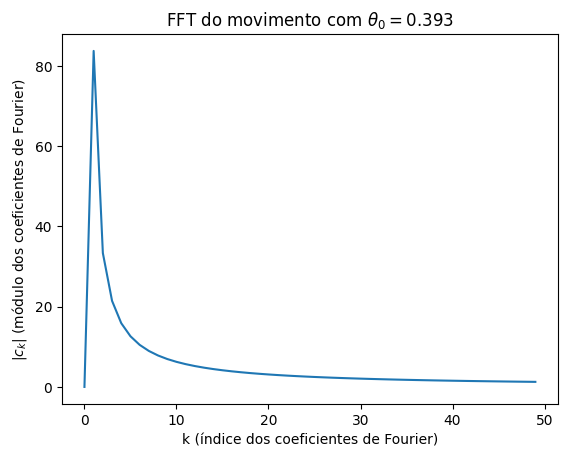

[  0.05  111.726  44.47   28.621  21.205  16.87   14.016  11.993  10.482
   9.311   8.376   7.612   6.977   6.44    5.979   5.581   5.233   4.925
   4.652   4.408   4.189   3.99    3.809   3.645   3.494   3.355   3.227
   3.108   2.998   2.896   2.801   2.711   2.628   2.549   2.475   2.405
   2.34    2.278   2.219   2.163   2.11    2.059   2.012   1.966   1.922
   1.881   1.841   1.803   1.766   1.731]


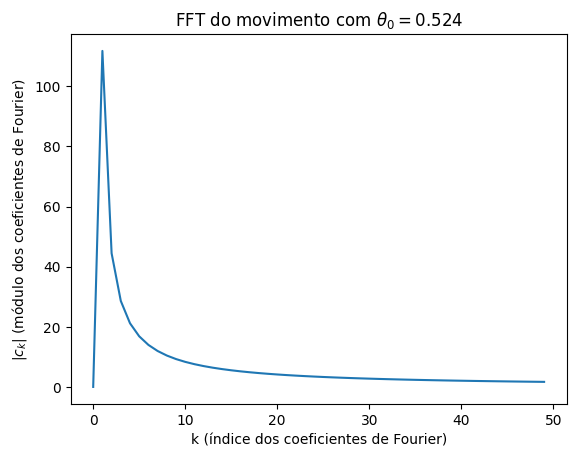

[  0.16  342.39  131.149  85.588  63.5    50.554  42.018  35.96   31.434
  27.924  25.122  22.833  20.927  19.316  17.936  16.741  15.696  14.775
  13.956  13.224  12.565  11.969  11.428  10.934  10.481  10.065   9.681
   9.325   8.995   8.688   8.401   8.134   7.883   7.647   7.425   7.216
   7.019   6.832   6.656   6.488   6.329   6.178   6.035   5.897   5.767
   5.642   5.522   5.408   5.299   5.194]


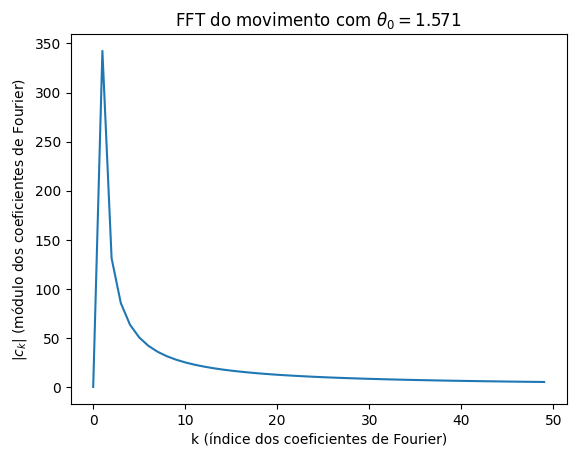

[  0.227 467.817 170.862 113.899  84.499  67.329  55.98   47.919  41.894
  37.22   33.487  30.437  27.897  25.75   23.912  22.319  20.926  19.698
  18.606  17.63   16.752  15.958  15.236  14.578  13.974  13.419  12.907
  12.433  11.993  11.584  11.202  10.845  10.51   10.196   9.9     9.621
   9.358   9.11    8.874   8.651   8.439   8.238   8.046   7.863   7.689
   7.522   7.363   7.211   7.065   6.925]


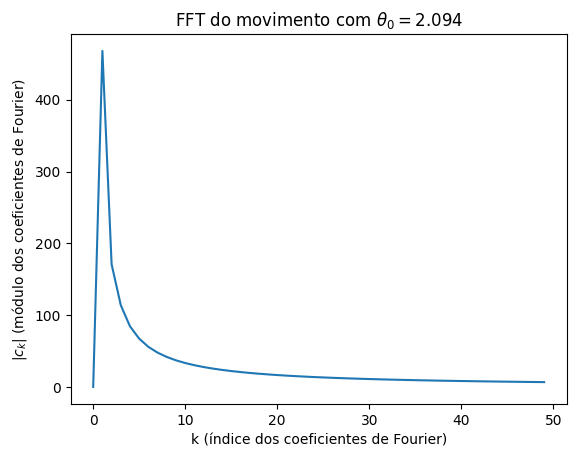

[  2.463 928.352 107.2   224.018 100.731 111.232  78.311  74.05   61.403
  56.278  49.803  45.716  41.689  38.604  35.793  33.444  31.344  29.515
  27.877  26.419  25.103  23.915  22.834  21.847  20.943  20.112  19.345
  18.635  17.976  17.363  16.79   16.255  15.754  15.283  14.84   14.423
  14.028  13.656  13.303  12.969  12.651  12.349  12.061  11.788  11.526
  11.277  11.038  10.81   10.591  10.382]


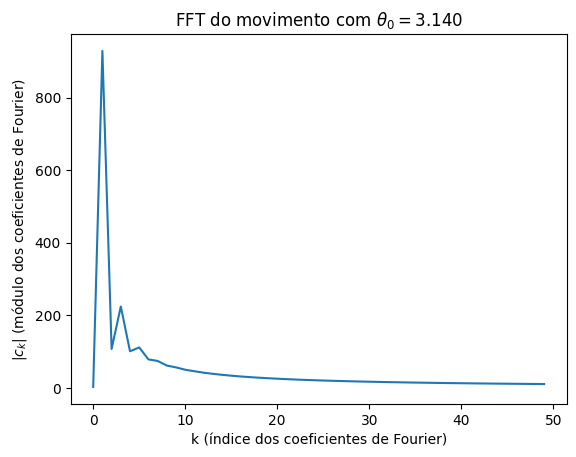

In [34]:
for th, tau in zip(thetas, tautau):
    # Obter os resultados
    tt, xx = rk4(0, tau/2, rhs, 500, np.array([th, 0]))
    aa, oo = np.array([i[0] for i in xx]), np.array([i[1] for i in xx])

    # Fazer a FFT (os ângulos são números reais)
    cc = np.fft.rfft(aa)

    with np.printoptions(precision=3, suppress=True):
        print(f"{np.abs(cc)[:50]}")

    # Representar graficamente
    plt.plot(np.abs(cc)[:50])
    plt.title(f"FFT do movimento com $\\theta_0 = {th:.3f}$")
    plt.xlabel("k (índice dos coeficientes de Fourier)")
    plt.ylabel("|$c_k$| (módulo dos coeficientes de Fourier)")
    plt.show()